# LAB6 — Pipeline de Processamento para Remoção de Ruído e Melhoria de Qualidade Visual

Disciplina: **Processamento Digital de Imagens (PDI)** – UFPel  
Professor: **Guilherme Corrêa**  

Vamos exercitar os conceitos estudados até o momento criando um pipeline de processamento de imagens.

Um pipeline de PDI é um fluxo com diversas operações executadas sequencialmente. No caso deste laboratório, vamos executar diversas operações para tentar melhorar a qualidade de uma imagem que tem baixa resolução, sofreu efeito de ruído periódico e também sofreu efeito de ruído sal & pimenta.

Use a imagem `tuyuka_lq.png` está disponível no repositório para os exercícios.

---

## Objetivos  

1. Aplicar conceitos estudados até este momento para melhorar a qualidade de uma imagem que tem baixa resolução, sofreu efeito de ruído periódico e também sofreu efeito de ruído sal & pimenta.
2. Você deve escolher quais passos de PDI aplicar e em qual ordem, considerando tudo o que estudamos até aqui (interpolação, realce, suavização, filtragem no domínio espacial, filtragem no domínio de transformadas...
3. **IMPORTANTE: a ordem de aplicação das técnicas vai influenciar muito no resultado final! Escolha sabiamente!**

---

## Bibliotecas úteis
Se estiver no Colab, rode a célula de instalação uma única vez.

In [1]:
# Se necessário no Colab, descomente a linha abaixo:
!pip -q install numpy matplotlib scikit-image imageio

In [2]:
# (execute uma vez)
!pip -q install ipywidgets==8.1.2 scikit-image==0.24.0 opencv-python-headless==4.10.0.84
from google.colab import output
output.enable_custom_widget_manager()

import numpy as np
import matplotlib.pyplot as plt
import cv2
from ipywidgets import interact, IntSlider
from skimage import filters, img_as_float
from skimage import io, color, img_as_ubyte
from google.colab import files



   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.4/139.4 kB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.0/15.0 MB 102.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.9/49.9 MB 14.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 82.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 68.1 MB/s eta 0:00:00


## Upload de uma imagem
Usando `files` do `google.colab` para fazer upload de uma imagem.

Faça upload de uma imagem (JPG/PNG).


Saving tuyuka_lq.png to tuyuka_lq.png


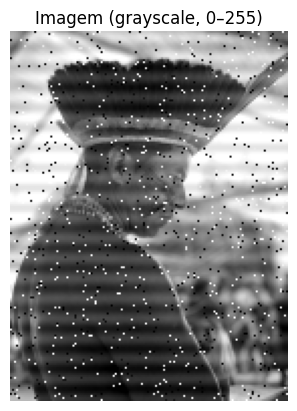

Dimensão: (184, 138)  | dtype: uint8  | Faixa: (np.uint8(0), np.uint8(255))


In [6]:

print("Faça upload de uma imagem (JPG/PNG).")
up = files.upload()
if not up:
    raise RuntimeError("Nenhum arquivo enviado.")

# Nome do arquivo
fname = next(iter(up))

# Ler imagem colorida (BGR)
img_bgr = cv2.imdecode(np.frombuffer(up[fname], np.uint8), cv2.IMREAD_COLOR)
if img_bgr is None:
    raise RuntimeError("Falha ao ler a imagem.")

# Converter para escala de cinza (uint8, faixa 0–255)
img_gray = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2GRAY)
img_orig = img_gray.astype(np.uint8)

# Mostrar
plt.imshow(img_orig, cmap='gray', vmin=0, vmax=255)
plt.axis('off')
plt.title('Imagem (grayscale, 0–255)')
plt.show()

print("Dimensão:", img_orig.shape, " | dtype:", img_orig.dtype, " | Faixa:", (img_orig.min(), img_orig.max()))


# 🖼️ Passo 1

usar a mediana da aula 4 tar b



In [16]:
import numpy as np
from PIL import Image
from pathlib import Path

def suaviza_mediana_3x3(figura):

    path = Path(figura)
    img = Image.open(path).convert("L")
    arr = np.asarray(img, dtype=np.uint8).astype(np.float32)

    # padding refletido (raio = 1)
    p = np.pad(arr, ((1,1),(1,1)), mode='reflect')

    # Cria array de saída
    out = np.zeros_like(arr)

    # Aplica mediana na vizinhança 3x3
    for i in range(arr.shape[0]):
        for j in range(arr.shape[1]):
            janela = p[i:i+3, j:j+3]
            out[i, j] = np.median(janela)

    out = np.clip(out, 0, 255).astype(np.uint8)

    out_path = path.with_name(path.stem + "_suave_mediana_3x3.bmp")
    Image.fromarray(out, mode="L").save(out_path, format="BMP")

    return str(out_path)



In [13]:
saida = suaviza_mediana_3x3("tuyuka_lq.png")
print("funciinou ", saida)

funciinou  tuyuka_lq_suave_mediana_3x3.bmp


/tmp/ipython-input-3272044536.py:29: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  Image.fromarray(out, mode="L").save(out_path, format="BMP")


# 🖼️ Passo 2
...

In [21]:
import numpy as np
from PIL import Image
from pathlib import Path
import cv2 # Necessário para a função circle, que é útil na criação da máscara

# A imagem de entrada para esta função será o resultado do Passo 1 (com o ruído sal & pimenta removido).
def remove_ruido_periodico(figura, u_pico, v_pico, raio_notch):
    """
    Remove ruído periódico usando um filtro Notch no domínio da frequência.

    Args:
        figura (str): Caminho para a imagem de entrada (resultado do Passo 1).
        u_pico (int): Coordenada da linha (frequência vertical) do pico de ruído.
        v_pico (int): Coordenada da coluna (frequência horizontal) do pico de ruído.
        raio_notch (int): Raio do círculo (em pixels) a ser zerado em torno do pico.
                          Use um valor pequeno, como 3, 5 ou 7.
    """
    path = Path(figura)
    # Abre a imagem de entrada (que já deve estar suave)
    img = Image.open(path).convert("L")
    arr = np.asarray(img, dtype=np.uint8).astype(np.float32)

    rows, cols = arr.shape

    # 1. Aplicar a Transformada de Fourier
    f = np.fft.fft2(arr)
    # 2. Deslocar o componente de frequência zero para o centro
    fshift = np.fft.fftshift(f)

    # Coordenadas do centro do espectro (DC)
    crow, ccol = rows // 2 , cols // 2

    # 3. Criação da Máscara (Filtro Notch)
    # A máscara começa com todos os valores em 1 (passa tudo)
    mask = np.ones((rows, cols), dtype=np.float32)

    # Identificação dos picos de ruído periódico:
    # O ruído periódico aparece como um pico em (u, v) e seu simétrico em (-u, -v)

    # Pico 1: Ruído original (adicionado ao centro do espectro)
    # (u_pico, v_pico) + (crow, ccol)
    cv2.circle(mask, (ccol + v_pico, crow + u_pico), raio_notch, 0, -1)

    # Pico 2: Ruído simétrico (subtraído do centro do espectro)
    # (-u_pico, -v_pico) + (crow, ccol)
    cv2.circle(mask, (ccol - v_pico, crow - u_pico), raio_notch, 0, -1)

    # Se houver mais de um par de picos de ruído na sua imagem (por exemplo, 4 picos),
    # você precisará adicionar mais chamadas a cv2.circle para zerar cada par simétrico.

    # 4. Aplicar o filtro no espectro
    fshift_filtered = fshift * mask

    # 5. Inverter o Deslocamento e a Transformada
    f_ishift = np.fft.ifftshift(fshift_filtered)
    img_back = np.fft.ifft2(f_ishift)

    # O resultado da IFFT é complexo, pegamos o valor absoluto
    img_passo2 = np.abs(img_back)

    # Normalizar e converter para uint8
    out = np.clip(img_passo2, 0, 255).astype(np.uint8)

    # Salva o resultado
    out_path = path.with_name(path.stem + "_periodico_removido.bmp")
    Image.fromarray(out, mode="L").save(out_path, format="BMP")

    return str(out_path)

# --- Exemplo de Uso (Você deve ajustar os parâmetros) ---
# A execução real dependerá do resultado do seu Passo 1.
# Por exemplo:
imagem_passo1 = suaviza_mediana_3x3('tuyuka_lq.png')
imagem_passo2 = remove_ruido_periodico(imagem_passo1, u_pico=20, v_pico=0, raio_notch=5)

/tmp/ipython-input-244517736.py:26: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  Image.fromarray(out, mode="L").save(out_path, format="BMP")
/tmp/ipython-input-506866005.py:66: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  Image.fromarray(out, mode="L").save(out_path, format="BMP")


aqui fiz a interpolação

In [25]:
import numpy as np
from PIL import Image
from pathlib import Path

def aumenta_resolucao(figura, nova_largura, nova_altura):
    """
    Aumenta a resolução da imagem usando interpolação Bicúbica.

    Args:
        figura (str): Caminho para a imagem de entrada (resultado do Passo 2).
        nova_largura (int): Largura desejada em pixels (colunas).
        nova_altura (int): Altura desejada em pixels (linhas).
    """
    path = Path(figura)
    # Abre a imagem de entrada (resultado do Passo 2)
    img = Image.open(path).convert("L")

    # Define o novo tamanho: (largura, altura)
    new_size = (nova_largura, nova_altura)

    # Redimensiona usando interpolação BICUBIC para melhor qualidade visual.
    # O uso de Image.Resampling.BICUBIC é a forma moderna.
    # Para compatibilidade com versões mais antigas do Pillow, Image.BICUBIC também funciona.
    try:
        # Tenta usar a forma moderna
        img_resampled = img.resize(new_size, resample=Image.Resampling.BICUBIC)
    except AttributeError:
        # Fallback para versões mais antigas
        img_resampled = img.resize(new_size, resample=Image.BICUBIC)

    # Salva o resultado
    out_path = path.with_name(path.stem + f"_res_{nova_largura}x{nova_altura}.bmp")
    img_resampled.save(out_path, format="BMP")

    return str(out_path)

# --- Exemplo de Uso ---
# Imagem atual: 138x184
# Tamanho desejado: 1535 (altura) x 2048 (largura)

# Se o resultado do Passo 2 foi 'tuyuka_lq_suave_mediana_3x3_periodico_removido.bmp', o uso seria:
imagem_passo2 = '/content/tuyuka_lq_suave_mediana_3x3_periodico_removido.bmp'
imagem_passo3 = aumenta_resolucao(
    figura=imagem_passo2,
     nova_largura=1535,
     nova_altura=2048
 )

In [ ]:
fazer realce com laplace lab 4

In [29]:
import numpy as np
from PIL import Image
from pathlib import Path

def realce_laplaciano_3x3(figura, k=1.0):
    """
    Realça (aguça) a imagem usando o operador Laplaciano 3x3.
    k: fator de realce (1.0 = realce padrão; >1.0 = mais forte; <1.0 = mais sutil)
    Salva BMP com sufixo '_realce_lap3x3'.
    """
    path = Path(figura)
    img = Image.open(path).convert("L")
    arr = np.asarray(img, dtype=np.float32)

    # padding refletido (raio = 1)
    p = np.pad(arr, ((1,1),(1,1)), mode='reflect')

    # Máscara Laplaciana 3x3 clássica (realce de bordas)
    lap = (
        1*p[0:-2, 0:-2] + 1*p[0:-2, 1:-1] + 1*p[0:-2, 2:] +
        1*p[1:-1, 0:-2] +  -8*p[1:-1, 1:-1] + 1*p[1:-1, 2:] +
        1*p[2:, 0:-2] + 1*p[2:, 1:-1] + 1*p[2:, 2:]
    )

    # Aguçamento: imagem + k * laplaciano
    out = arr + k * lap

    # Normaliza e salva
    out = np.clip(out, 0, 255).astype(np.uint8)
    out_path = path.with_name(path.stem + "_realce_laplaciano_3x3.bmp")
    Image.fromarray(out, mode="L").save(out_path, format="BMP")

    return str(out_path)

# Usar a função com o caminho da imagem fornecido
imagem_para_realce = '/content/tuyuka_lq_suave_mediana_3x3_periodico_removido_res_1535x2048.bmp'
imagem_realcada = realce_laplaciano_3x3(imagem_para_realce)
print(f"Imagem realçada salva em: {imagem_realcada}")


Imagem realçada salva em: /content/tuyuka_lq_suave_mediana_3x3_periodico_removido_res_1535x2048_realce_laplaciano_3x3.bmp


/tmp/ipython-input-661051885.py:31: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  Image.fromarray(out, mode="L").save(out_path, format="BMP")


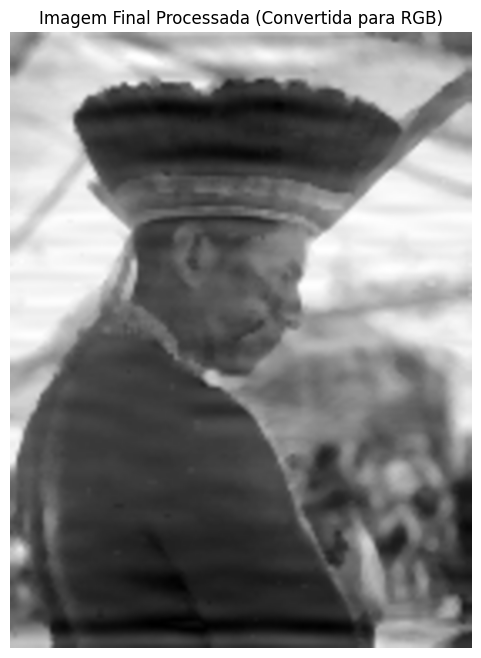

Imagem final RGB salva em: /content/tuyuka_lq_suave_mediana_3x3_periodico_removido_res_1535x2048_realce_laplaciano_3x3_rgb_final.bmp


In [27]:
from PIL import Image
from pathlib import Path
import matplotlib.pyplot as plt

# A variável 'imagem_realcada' guarda o caminho da última imagem processada em escala de cinza.
# Seu valor atual é: '/content/tuyuka_lq_suave_mediana_3x3_periodico_removido_res_1535x2048_realce_laplaciano_3x3.bmp'

# Abrir a imagem em escala de cinza
img_gray_processed = Image.open(imagem_realcada)

# Converter para o modo RGB. Isso irá replicar os valores de intensidade da escala de cinza
# para todos os três canais (Vermelho, Verde, Azul), resultando em uma imagem colorida que parece em escala de cinza.
img_rgb_final = img_gray_processed.convert("RGB")

# Exibir a imagem convertida
plt.figure(figsize=(10, 8))
plt.imshow(img_rgb_final)
plt.title('Imagem Final Processada (Convertida para RGB)')
plt.axis('off')
plt.show()

# Salvar a imagem RGB resultante
output_path_rgb = Path(imagem_realcada).with_name(Path(imagem_realcada).stem + "_rgb_final.bmp")
img_rgb_final.save(output_path_rgb, format="BMP")

print(f"Imagem final RGB salva em: {output_path_rgb}")
